In [1]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
# A method to extract a and y values of any stock from the Alpha Vantage API
def extract_x_y(ticker):
    url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=" + ticker + "&outputsize=full&apikey=RY9JPRE2OAC80KJL"
    r = requests.get(url)
    data = r.json()

    df = pd.DataFrame()

    for i in data['Time Series (Daily)'].keys():
      row = {'Date': i, 
             'Open': data['Time Series (Daily)'][i]['1. open'], 
             'High': data['Time Series (Daily)'][i]['2. high'], 
             'Low': data['Time Series (Daily)'][i]['3. low'], 
             'Close': data['Time Series (Daily)'][i]['4. close'], 
             'Volume': data['Time Series (Daily)'][i]['5. volume']}

      df = df.append(row, ignore_index=True)
    
    df.sort_values(by=['Date'])
    df['Date'] = pd.to_datetime(df.Date)

    return df

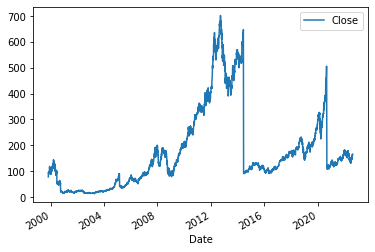

In [3]:
# Processing the values returned from the API Call
stock_prices = extract_x_y('AAPL')

stock_prices.head(10)

stock_prices['Open'] = stock_prices['Open'].replace({'\$':''}, regex=True).astype(float)
stock_prices['High'] = stock_prices['High'].replace({'\$':''}, regex=True).astype(float)
stock_prices['Low'] = stock_prices['Low'].replace({'\$':''}, regex=True).astype(float)
stock_prices['Close'] = stock_prices['Close'].replace({'\$':''}, regex=True).astype(float)
stock_prices['Volume'] = stock_prices['Volume'].replace({'\$':''}, regex=True).astype(float)

stock_prices.plot(x="Date", y="Close")

In [4]:
# Dividing the data into 80% trainging data and 20% testing data
training_split_ratio = 0.8
split_point = int(np.ceil(len(stock_prices) * training_split_ratio))

training_data = stock_prices[:split_point]
testing_data = stock_prices[split_point:]

In [5]:
# Seperating the Close values for our model
training_set = training_data.iloc[:, 4:5].values
true_stock_price = testing_data.iloc[:, 4:5].values

In [6]:
# Normalizing the current close values for better prediction
scaler = MinMaxScaler(feature_range=(0,1))
training_data_normalized = scaler.fit_transform(training_set)
training_data_normalized

array([[2.03044330e-01],
       [2.02970150e-01],
       [2.03682274e-01],
       ...,
       [1.63195063e-04],
       [6.67616165e-04],
       [5.19257017e-04]])

In [7]:
# LSTM training requires a window in each training step.
# If the window size is 10 then the model will predict the 10th value with the information of previous 9 values
# Here x will contain the n-1 previous dependent values and the nth value that has to be predicted
# And y will contain the actual value that was being predicted

def lstm_data_divide(data, num_of_steps):
  x = []
  y = []
  for i in range(num_of_steps, len(data)):
    x.append(data[i - num_of_steps:i, 0])
    y.append(data[i, 0])
  return np.array(x), np.array(y)

In [8]:
# Here the number of steps is 60
num_of_steps = 60
x_arr, y_arr = lstm_data_divide(training_data_normalized, num_of_steps)

In [9]:
# Building the LSTM Model with different layers
tf_model = tf.keras.models.Sequential()
tf_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(x_arr.shape[1], 1)))
tf_model.add(tf.keras.layers.Dropout(0.2))
tf_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
tf_model.add(tf.keras.layers.Dropout(0.2))
tf_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
tf_model.add(tf.keras.layers.Dropout(0.2))
tf_model.add(tf.keras.layers.LSTM(units=50))
tf_model.add(tf.keras.layers.Dropout(0.2))
tf_model.add(tf.keras.layers.Dense(units=1))
tf_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [10]:
# Compile the model with Adam's Optimizer and MeanSquaredError method for loss reduction
tf_model.compile(optimizer='adam', loss='MeanSquaredError')

In [11]:
# Training the model with the pre-processed values
model_optimized = tf_model.fit(x_arr, y_arr, epochs=10, batch_size=32)

Epoch 1/10
142/142 [==============================] - 25s 121ms/step - loss: 0.0088
Epoch 2/10
142/142 [==============================] - 17s 121ms/step - loss: 0.0037
Epoch 3/10
142/142 [==============================] - 18s 129ms/step - loss: 0.0030
Epoch 4/10
142/142 [==============================] - 18s 127ms/step - loss: 0.0027
Epoch 5/10
142/142 [==============================] - 18s 125ms/step - loss: 0.0024
Epoch 6/10
142/142 [==============================] - 17s 121ms/step - loss: 0.0022
Epoch 7/10
142/142 [==============================] - 17s 123ms/step - loss: 0.0021
Epoch 8/10
142/142 [==============================] - 17s 121ms/step - loss: 0.0019
Epoch 9/10
142/142 [==============================] - 19s 131ms/step - loss: 0.0018
Epoch 10/10
142/142 [==============================] - 18s 124ms/step - loss: 0.0017


In [12]:
# Combining the training and testing data to predict the price of from that data
complete_data = pd.concat([training_data['Close'], testing_data['Close']], axis=0)

inputs = complete_data[len(complete_data) - len(testing_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

x_test = []

for i in range(60, len(testing_data)):
  x_test.append(inputs[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [13]:
# Predicting the future values from the testing data using our model 
prediction = tf_model.predict(x_test)

In [14]:
# We need to bring back the original values of the normalized values
prediction = scaler.inverse_transform(prediction)

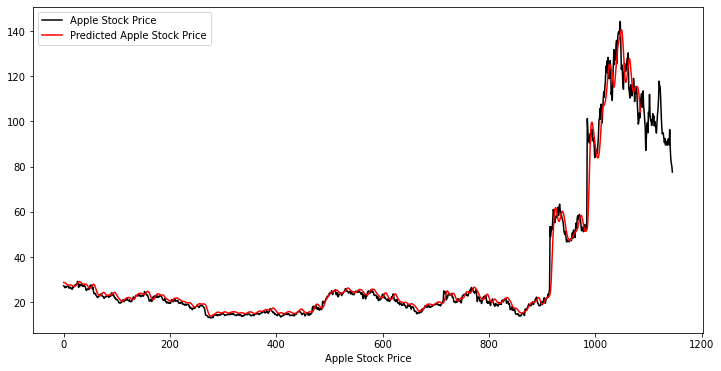

In [15]:
# Plotting the graph of both the actual and the predicted results
plt.figure(figsize=(12, 6))

plt.plot(true_stock_price, color='black', label='Apple Stock Price')
plt.plot(prediction, color='red', label='Predicted Apple Stock Price')

plt.xlabel('Time')
plt.xlabel('Apple Stock Price')
plt.legend()
plt.show()